In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import torch
import torchvision
import torchvision.transforms.v2 as v2

In [3]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

trainset = torchvision.datasets.MNIST(root="data", download=True, train=True, transform=transform)

In [4]:
image, label = trainset[44]

In [5]:
import matplotlib.pyplot as plt

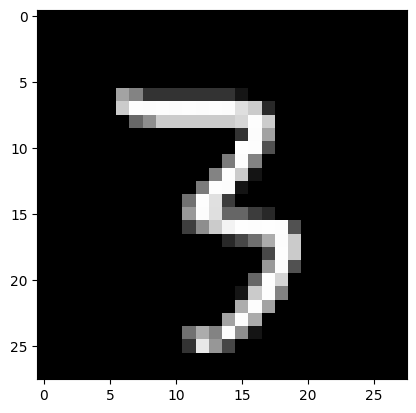

In [6]:
plt.imshow(image[0], cmap="grey")

In [7]:
import numpy as np

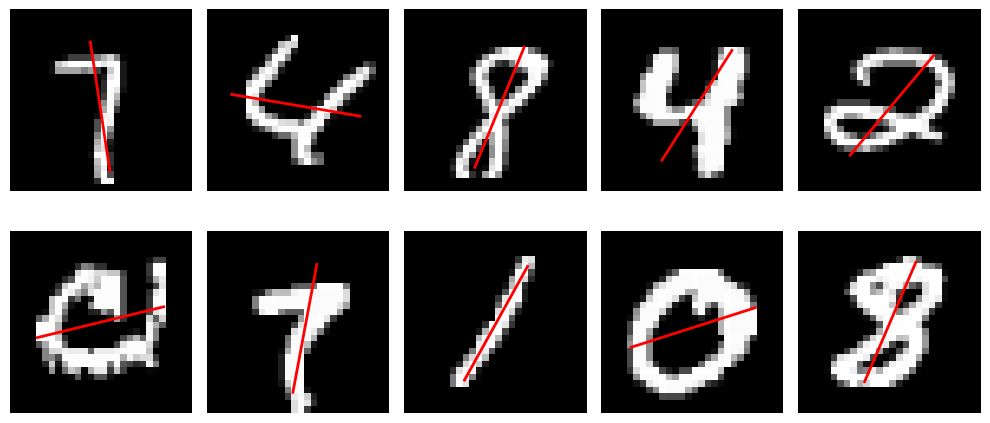

In [10]:
indices = torch.randperm(len(trainset))[:10]  # Select 10 random indices
samples = torch.stack([trainset[i][0].squeeze(0) for i in indices])  # Extract images

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, img in enumerate(samples):
    img_numpy = img.numpy()
    
    # Extract white pixel coordinates (assuming higher intensity means more white)
    threshold = 0.1  # Adjust if necessary
    yx_coords = np.column_stack(np.where(img_numpy > threshold))  # Get (y, x) pairs

    if len(yx_coords) > 1:  # Avoid PCA failure for empty/constant images
        yx_mean = yx_coords.mean(axis=0)  # Compute centroid
        yx_coords_centered = yx_coords - yx_mean  # Center coordinates

        # Compute PCA on white pixel coordinates
        U, S, V = torch.pca_lowrank(torch.tensor(yx_coords_centered, dtype=torch.float32), q=1)
        main_component = V[:, 0].numpy()  # First principal component

        # Compute vector for visualization
        start = yx_mean - main_component * 10  # Scale for visualization
        end = yx_mean + main_component * 10

        ax = axes[i // 5, i % 5]
        ax.imshow(img_numpy, cmap="gray")
        ax.plot([start[1], end[1]], [start[0], end[0]], color="red", linewidth=2)  # PCA vector
        ax.axis("off")

plt.tight_layout()
plt.show()

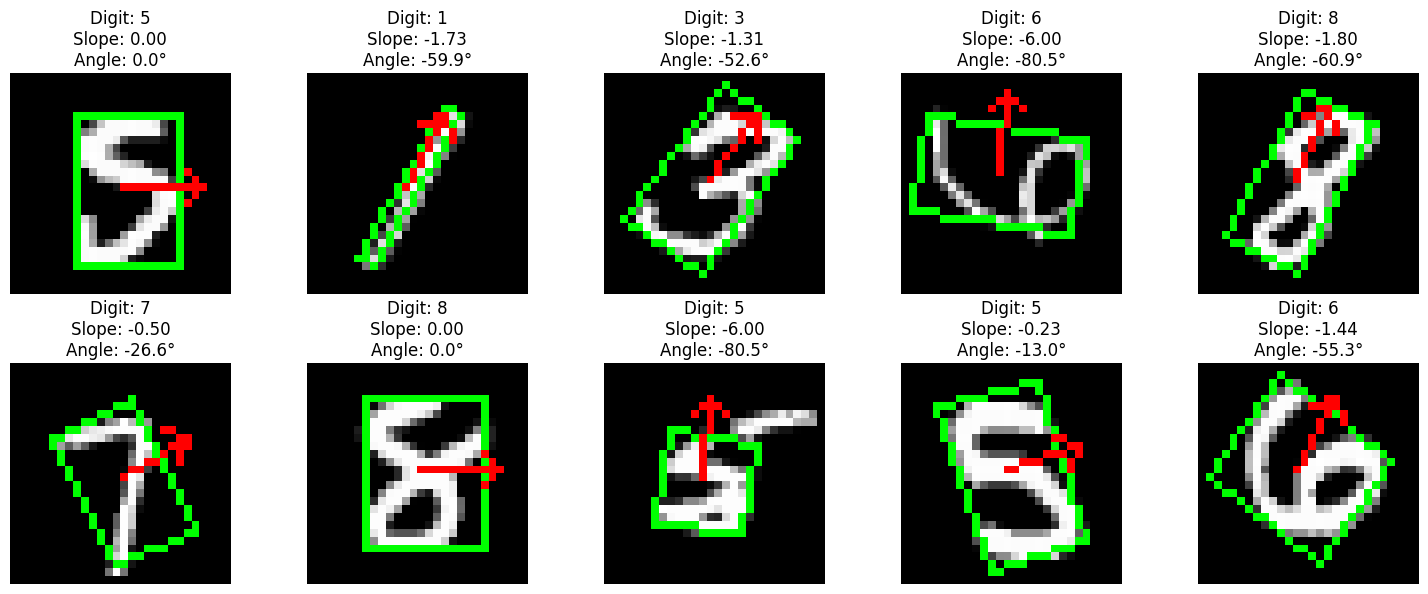

In [11]:
import numpy as np
import cv2
from torchvision import datasets
import matplotlib.pyplot as plt
import random

# Function to calculate bounding box, slope, and draw direction vector
def get_bounding_box_slope(image):
    # Convert from [-1, 1] to [0, 255] range
    img = ((image + 1) * 127.5).astype(np.uint8)  # Scale from [-1,1] to [0,255]
    
    # Threshold the image
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        
        # Get minimum area rectangle
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = box.astype(int) 
        
        # Calculate slope (using two adjacent points)
        dx = box[1][0] - box[0][0]
        dy = box[1][1] - box[0][1]
        slope = dy / (dx + 1e-10)  # Add small epsilon to avoid div by zero
        angle = np.arctan(slope) * 180 / np.pi
        
        # Calculate center of bounding box
        center = np.mean(box, axis=0).astype(int)
        
        # Calculate direction vector endpoint (length = 10 pixels)
        vector_length = 10
        end_x = int(center[0] + vector_length * np.cos(np.arctan(slope)))
        end_y = int(center[1] + vector_length * np.sin(np.arctan(slope)))
        
        return box, slope, angle, center, (end_x, end_y)
    return None, None, None, None, None

# Select 10 random images
num_images = 10
random_indices = random.sample(range(len(trainset)), num_images)

# Create figure for plotting
plt.figure(figsize=(15, 6))

# Process and display each image
for i, idx in enumerate(random_indices):
    # Get image and convert from tensor to numpy
    image, label = trainset[idx]
    image = image.squeeze().numpy()  # Remove channel dimension
    
    # Get bounding box, slope, and vector info
    box, slope, angle, center, vector_end = get_bounding_box_slope(image)
    
    if box is not None:
        # Convert image to 3 channels for color drawing
        img_color = ((image + 1) * 127.5)  # Scale to [0,255]
        img_color = cv2.cvtColor(img_color.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        
        # Draw bounding box in green
        cv2.drawContours(img_color, [box], 0, (0, 255, 0), 1)
        
        # Draw direction vector in red
        if center is not None and vector_end is not None:
            cv2.arrowedLine(img_color, tuple(center), vector_end, (255, 0, 0), 1, tipLength=0.3)
        
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_color)
        plt.title(f'Digit: {label}\nSlope: {slope:.2f}\nAngle: {angle:.1f}°')
        plt.axis('off')

plt.tight_layout()
plt.show()

## Dataset

In [12]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((32, 32), interpolation=v2.InterpolationMode.NEAREST),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

trainset = torchvision.datasets.MNIST(root="data", download=True, train=True, transform=transform)

In [13]:
class MNISTIncline(torchvision.datasets.MNIST):
    def __init__(self, root, train = True, transform = None, target_transform = None, download = False, threshold=0.1):
        super().__init__(root, train, transform, target_transform, download)

        self.threshold = threshold
    
    def _calculate_slope_angle(self, img):
        img_numpy = img.numpy()
        yx_coords = np.column_stack(np.where(img_numpy > self.threshold))
        yx_mean = yx_coords.mean(axis=0)
        yx_coords_centered = yx_coords - yx_mean 

        U, S, V = torch.pca_lowrank(torch.tensor(yx_coords_centered, dtype=torch.float32), q=1)
        main_component = V[:, 0].numpy()[::-1]
        if main_component[1] > 0:
            main_component *= -1
        
        slope_angle = torch.pi / 2 + np.atan2(main_component[1], main_component[0])

        return slope_angle
    
    def __getitem__(self, index):
        img, label = super().__getitem__(index)

        slope_angle = self._calculate_slope_angle(img)
        return img, label, slope_angle 

In [14]:
trainset = MNISTIncline(root="data", download=True, train=True, transform=transform)

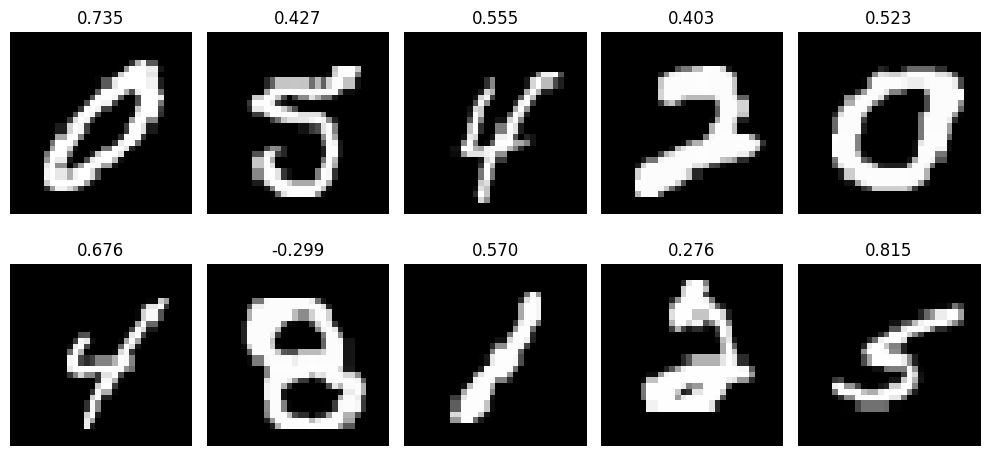

In [15]:
indices = torch.randperm(len(trainset))[:10]  # Select 10 random indices
samples = [trainset[i] for i in indices]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, batch in enumerate(samples):
    img, label, slope_angle = batch

    ax = axes[i // 5, i % 5]
    ax.imshow(img[0].numpy(), cmap="gray")
    ax.set_title(f"{slope_angle.item():.3f}")

    ax.axis("off")


plt.tight_layout()
plt.show()

## EfficientNet 

In [10]:
from torchvision import models

In [ ]:
model = models.efficientnet_b0(pretrained=True, )

/xfs/yaz/mnist/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/xfs/yaz/mnist/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/yaz/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 189MB/s]


In [14]:
transform = v2.Compose([
    v2.Grayscale(3),   # Convert 1-channel to 3-channel
    v2.Resize((224, 224)),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

In [25]:
img = transform(image.unsqueeze(0))

In [26]:
vec = model(img)

In [27]:
vec.shape

torch.Size([1, 1000])